In [1]:
import re
from functools import cache
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
from joblib import dump
from scipy import stats
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor,
                              ExtraTreesRegressor, GradientBoostingRegressor,
                              HistGradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

2022-11-27 18:46:11.118333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 18:46:11.554193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-27 18:46:11.554239: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-27 18:46:11.614101: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-27 18:46:12.612003: W tensorflow/stream_executor/platform/de

In [2]:
%matplotlib inline

In [3]:
print(f"scikit-learn Version: {sklearn.__version__}")
print(f"TensorFlow Version: {tf.__version__}")

scikit-learn Version: 1.1.3
TensorFlow Version: 2.10.0


In [4]:
def trim_string(string: str, fill: str = ' ') -> str:
    return fill.join(filter(lambda _: _, re.split(r"\W", string))).lower()

In [5]:
@cache
def get_data_frame() -> pd.DataFrame:
    return pd.read_csv("../data/raw/dataset.csv")

In [6]:
def get_X_y(df: pd.DataFrame) -> tuple[np.ndarray]:
    return df.iloc[:, :4].values, df.iloc[:, 4:].values

In [7]:
def plot_model_train_val_losses(history_dict: dict[str, list[float]]) -> None:
    """
    Plots Train & Validation Losses per Epoch
    """
    plt.figure(figsize=(8, 5))
    for array in history_dict.values():
        plt.plot(array)

    plt.title("Loss Plot")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend(history_dict.keys())
    plt.grid()
    plt.show()

In [8]:
def plot_multi_output_solver(
    y_test: np.ndarray,
    y_pred: np.ndarray,
    solver,
    size: int = 50,
    alpha: float = .4
) -> None:
    assert y_test.shape[1] == 2 and y_pred.shape[1] == 2

    caption = solver.get_params()["estimator"] if isinstance(
        solver, MultiOutputRegressor
    ) else type(solver).__name__

    plt.figure()
    plt.scatter(
        y_test[:, 0],
        y_test[:, 1],
        edgecolor="k",
        c="navy",
        s=size,
        marker="s",
        alpha=alpha,
        label="Data",
    )
    plt.scatter(
        y_pred[:, 0],
        y_pred[:, 1],
        edgecolor="k",
        c="cornflowerblue",
        s=size,
        alpha=alpha,
        label=(
            f"MAE: {maes[caption]:,.6f}; "
            f"MSE: {mses[caption]:,.6f}; "
            f"$R^2$: {r2_s[caption]:,.6f}"
        )
    )
    plt.xlim([-3, 3])
    plt.ylim([-2, 4])
    plt.xlabel("depth")
    plt.ylabel("width")
    plt.title(caption)
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

# Constants

In [9]:
DESCRIPTION = {
    'IW': 'Величина сварочного тока',
    'IF': 'Ток фокусировки электронного пучка',
    'VW': 'Скорость сварки',
    'FP': 'Расстояние от поверхности образцов до электронно-оптической системы',
    'Depth': 'Глубина шва',
    'Width': 'Ширина шва'
}
CV = 5
RANDOM_STATE = 42
MODEL_DIR = "../models"

# Data Collection

In [10]:
df = get_data_frame()

# Data Preprocessing

In [11]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(data=scaler.fit_transform(df), columns=df.columns)

# Exploratory Data Analysis, EDA

In [12]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


## Variance Inflation Factor

In [13]:
vif = pd.DataFrame(
    data=(
        (column, variance_inflation_factor(df_scaled.values, _))
        for _, column in enumerate(df_scaled.columns)
    ),
    columns=("features", "vif_Factor")
)
vif

features  vif_Factor
0       IW    4.651686
1       IF   64.127479
2       VW   14.972344
3       FP   76.071828
4    Depth    5.777209
5    Width   19.457122

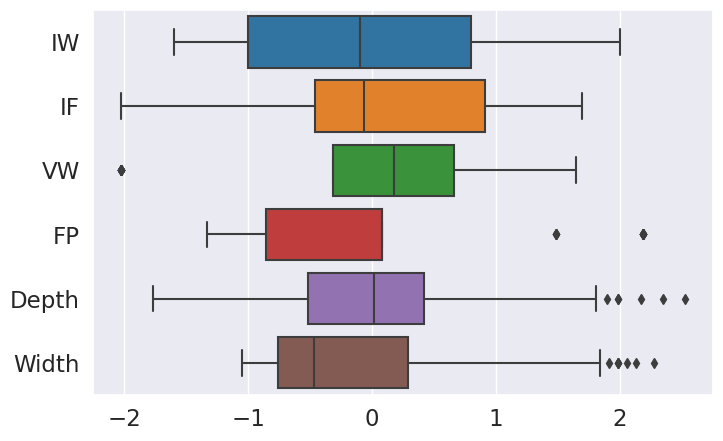

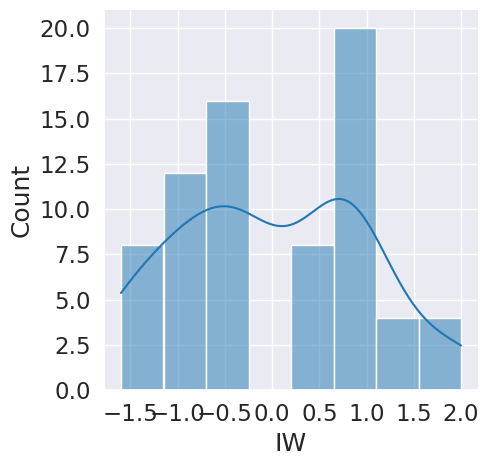

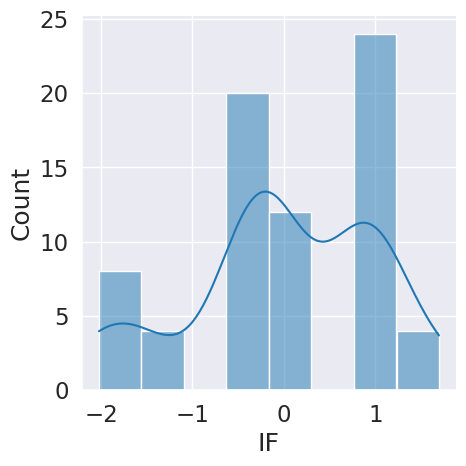

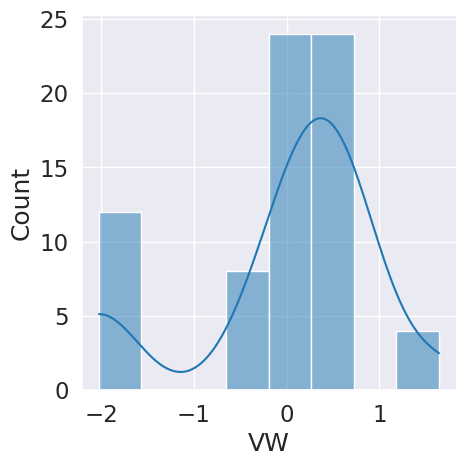

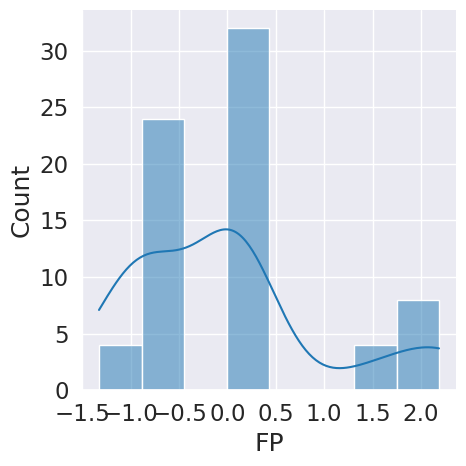

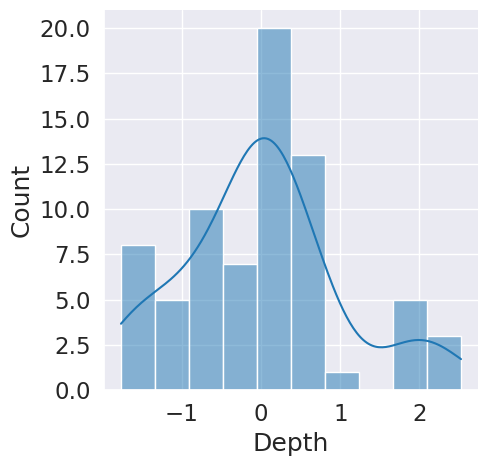

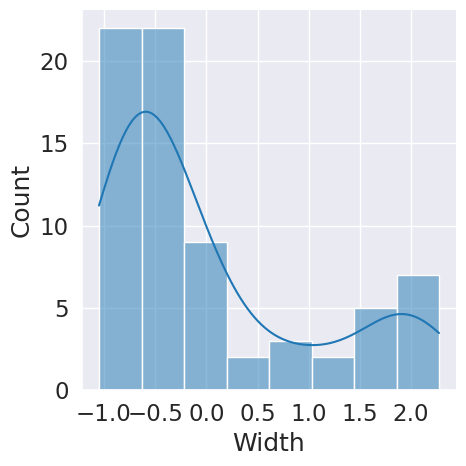

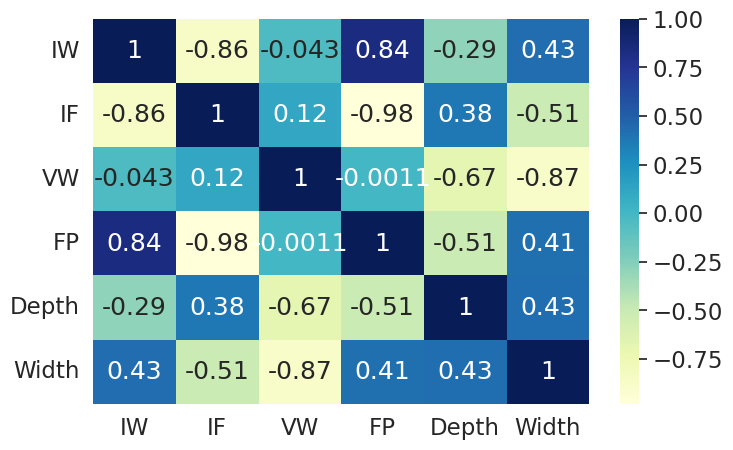

<Figure size 800x500 with 0 Axes>

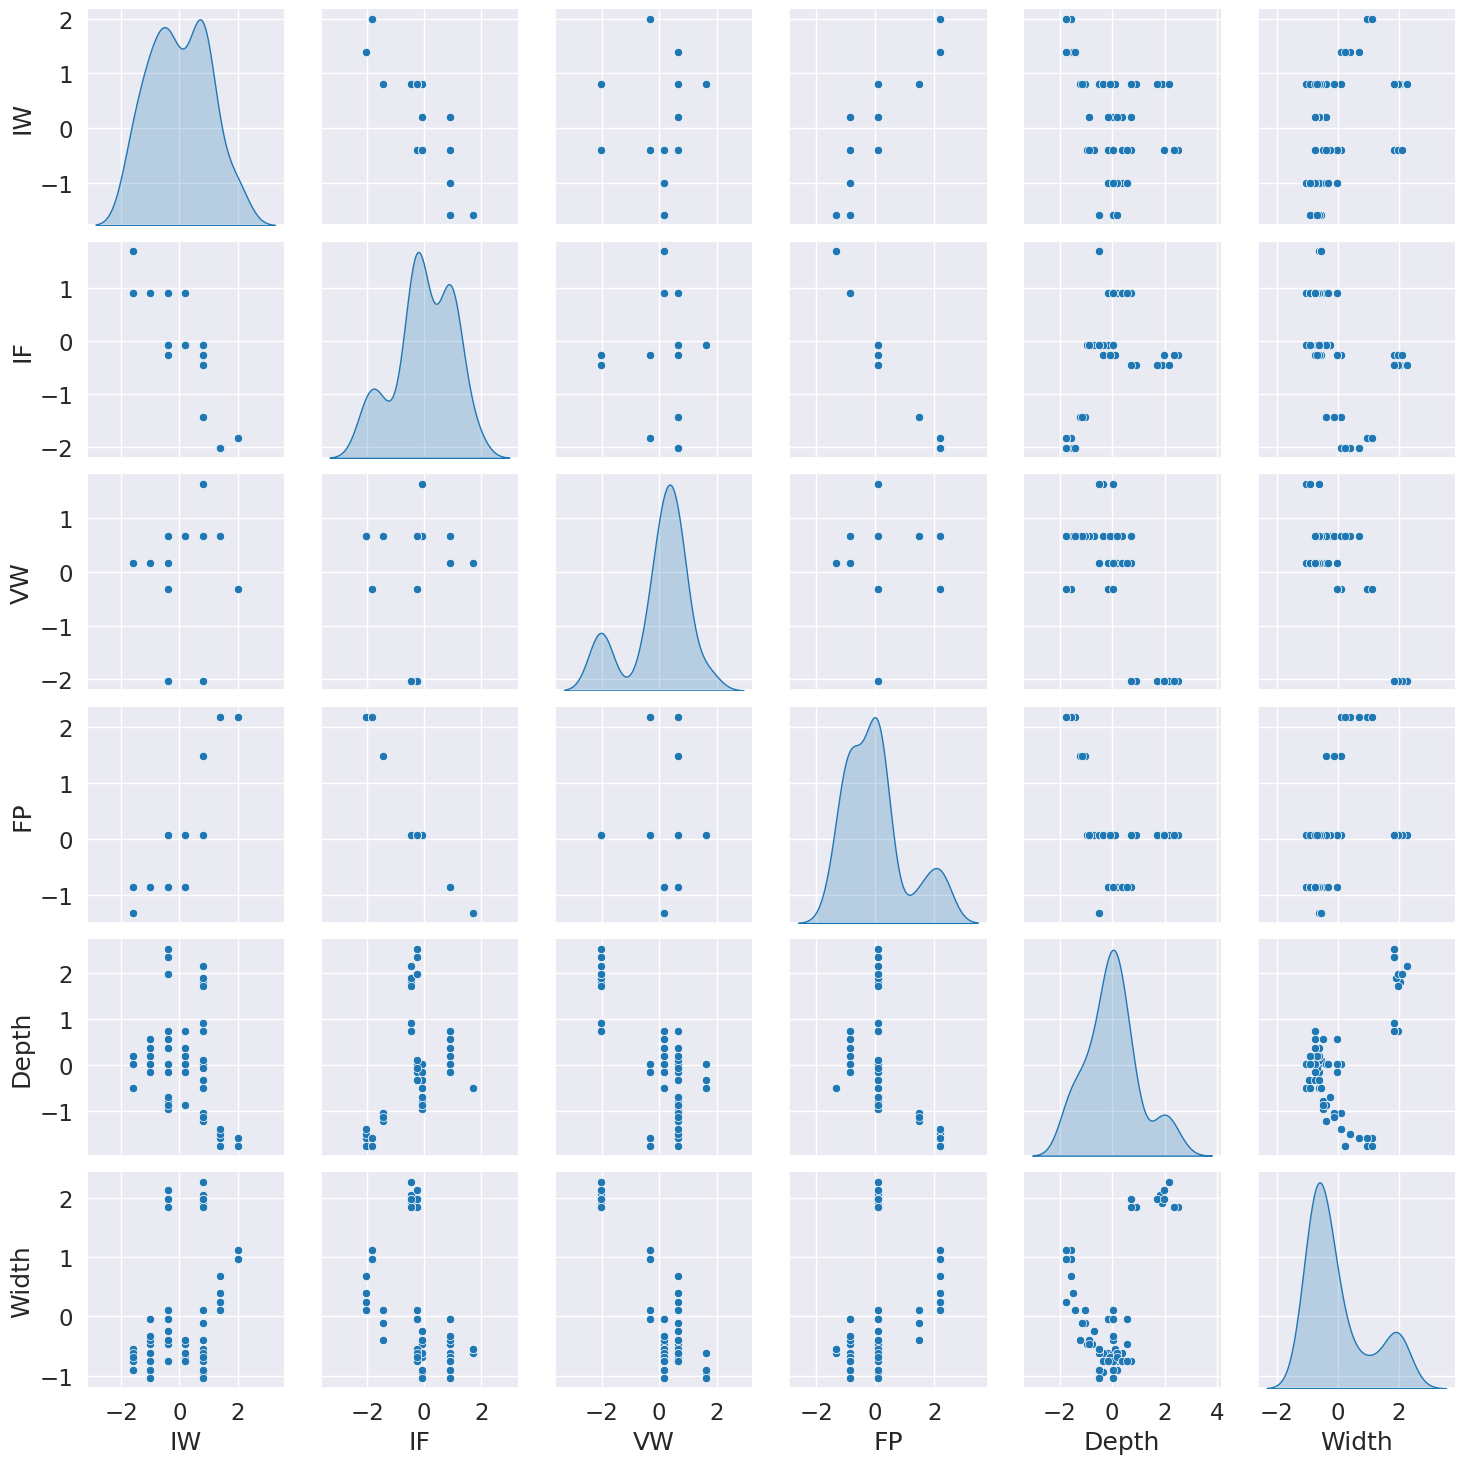

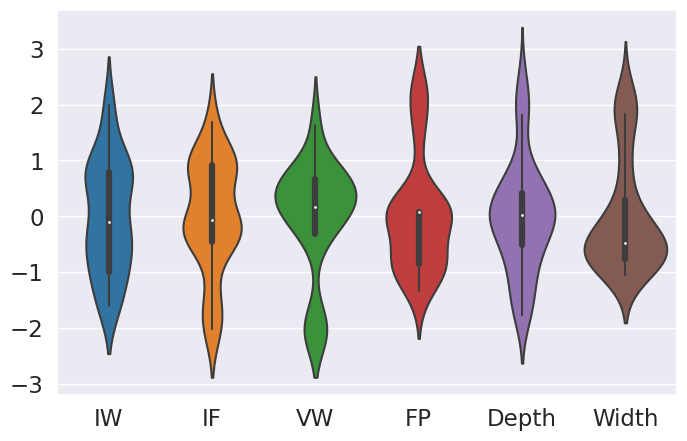

In [14]:
with sns.axes_style('darkgrid'):
    with sns.plotting_context('notebook', font_scale=1.5):
        # =====================================================================
        # Box Plot
        # =====================================================================
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df_scaled, orient="h")

        # =====================================================================
        # Distribution Plot
        # =====================================================================
        for column in df_scaled.columns:
            sns.displot(data=df_scaled, x=column, kde=True)

        # =====================================================================
        # Correlation Matrix
        # =====================================================================
        plt.figure(figsize=(8, 5))
        sns.heatmap(data=df_scaled.corr(), cmap="YlGnBu", annot=True)

        # =====================================================================
        # Pair Plot
        # =====================================================================
        plt.figure(figsize=(8, 5))
        sns.pairplot(data=df_scaled, diag_kind="kde")

        # =====================================================================
        # Violin Plot
        # =====================================================================
        plt.figure(figsize=(8, 5))
        sns.violinplot(data=df_scaled)

# $\sigma = 1.4$ is the Optimum for Trimming In Terms of Outliers

In [15]:
# df_trimmed = df_scaled[(np.abs(stats.zscore(df_scaled)) < 1.4).all(axis=1)]
# # df_trimmed

# ML Models

## Get Features

In [16]:
X, y = df_scaled.pipe(get_X_y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)

## scikit-learn: Linear Models

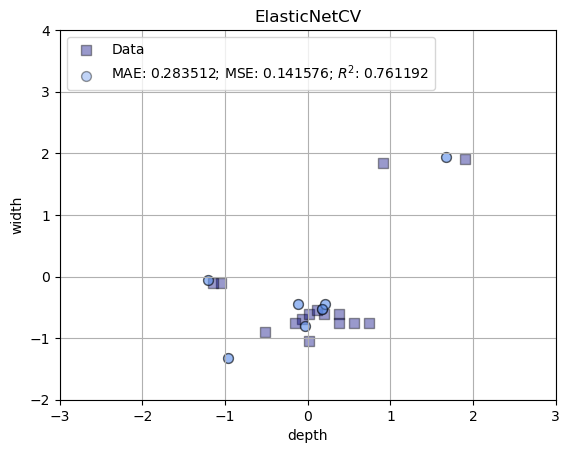

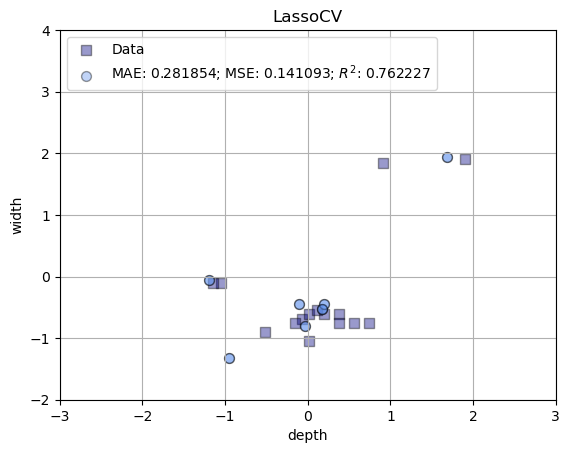

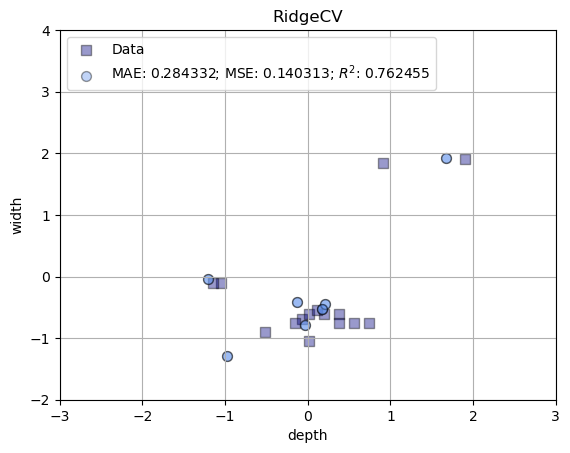

Linear Models Results:
Best Solver In Terms of <MAE> Is: LassoCV = 0.281854
Best Solver In Terms of <MSE> Is: RidgeCV = 0.140313
Best Solver In Terms of <R**2> Is: RidgeCV = 0.762455


In [17]:
maes, mses, r2_s = {}, {}, {}

for solver in (
    ElasticNetCV(cv=CV, random_state=RANDOM_STATE),
    LassoCV(cv=CV, random_state=RANDOM_STATE),
    RidgeCV(cv=CV)
):
    regr_multirf = MultiOutputRegressor(solver)
    regr_multirf.fit(X_train, y_train)
    y_pred = regr_multirf.predict(X_test)

    maes[type(solver).__name__] = mean_absolute_error(y_test, y_pred)
    mses[type(solver).__name__] = mean_squared_error(y_test, y_pred)
    r2_s[type(solver).__name__] = r2_score(y_test, y_pred)

    # =========================================================================
    # Plot the Results
    # =========================================================================
    plot_multi_output_solver(y_test, y_pred, solver)
    
    # =========================================================================
    # Save Model
    # =========================================================================
    file_name = f'sklearn_linear_models_{type(solver).__name__.lower()}.joblib'
    dump(solver, Path(MODEL_DIR).joinpath(file_name))


best_mae = min(maes, key=maes.get)
best_mse = min(mses, key=mses.get)
best_r_2 = max(r2_s, key=r2_s.get)
print("Linear Models Results:")
print(f"Best Solver In Terms of <MAE> Is: {best_mae} = {maes[best_mae]:,.6f}")
print(f"Best Solver In Terms of <MSE> Is: {best_mse} = {mses[best_mse]:,.6f}")
print(f"Best Solver In Terms of <R**2> Is: {best_r_2} = {r2_s[best_r_2]:,.6f}")

## scikit-learn: Ensembles

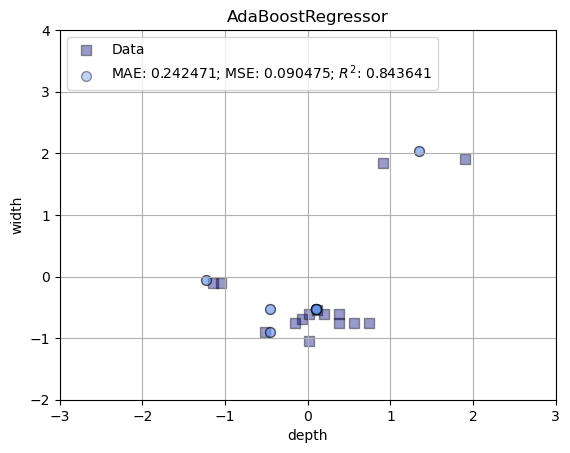

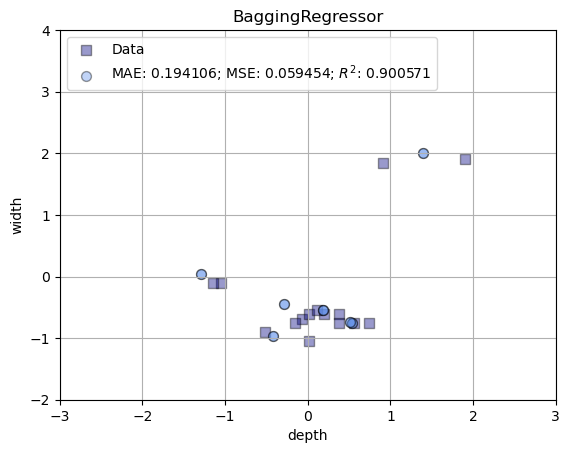

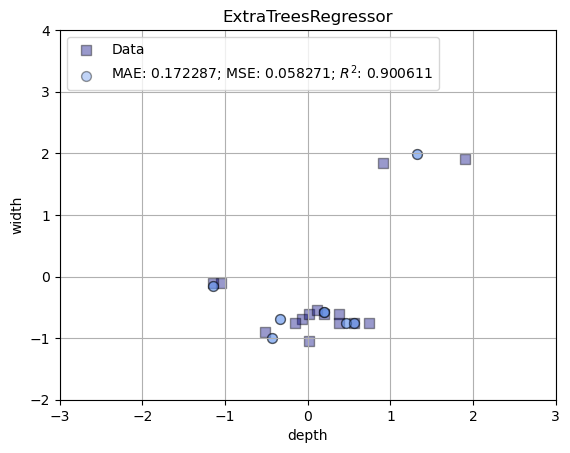

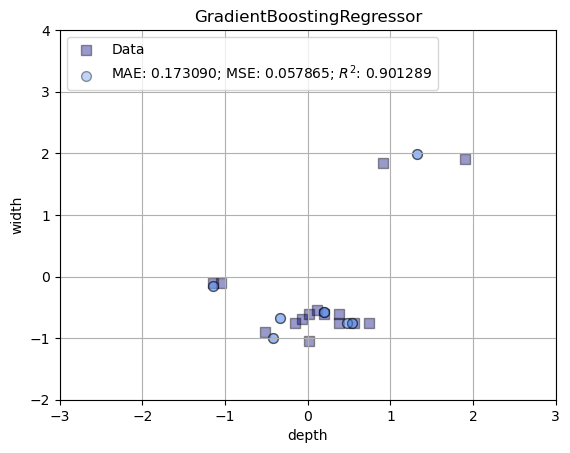

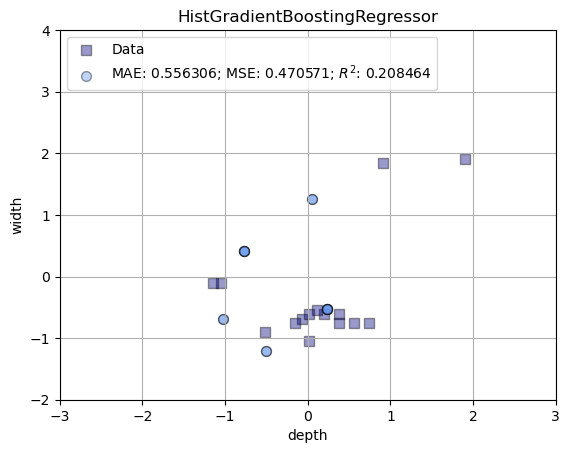

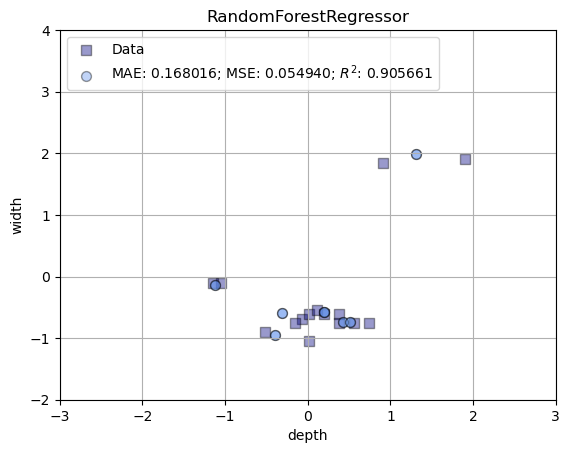

Ensembles Results:
Best Solver In Terms of <MAE> Is: RandomForestRegressor = 0.168016
Best Solver In Terms of <MSE> Is: RandomForestRegressor = 0.054940
Best Solver In Terms of <R**2> Is: RandomForestRegressor = 0.905661


In [18]:
maes, mses, r2_s = {}, {}, {}

for solver in (
    AdaBoostRegressor(random_state=RANDOM_STATE),
    BaggingRegressor(random_state=RANDOM_STATE),
    ExtraTreesRegressor(random_state=RANDOM_STATE),
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    HistGradientBoostingRegressor(random_state=RANDOM_STATE),
    RandomForestRegressor(random_state=RANDOM_STATE),
):
    regressor = MultiOutputRegressor(solver)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    maes[type(solver).__name__] = mean_absolute_error(y_test, y_pred)
    mses[type(solver).__name__] = mean_squared_error(y_test, y_pred)
    r2_s[type(solver).__name__] = r2_score(y_test, y_pred)

    # =========================================================================
    # Plot the Results
    # =========================================================================
    plot_multi_output_solver(y_test, y_pred, solver)
    
    # =========================================================================
    # Save Model
    # =========================================================================
    file_name = f'sklearn_ensembles_{type(solver).__name__.lower()}.joblib'
    dump(solver, Path(MODEL_DIR).joinpath(file_name))


best_mae = min(maes, key=maes.get)
best_mse = min(mses, key=mses.get)
best_r_2 = max(r2_s, key=r2_s.get)
print("Ensembles Results:")
print(f"Best Solver In Terms of <MAE> Is: {best_mae} = {maes[best_mae]:,.6f}")
print(f"Best Solver In Terms of <MSE> Is: {best_mse} = {mses[best_mse]:,.6f}")
print(f"Best Solver In Terms of <R**2> Is: {best_r_2} = {r2_s[best_r_2]:,.6f}")

## scikit-learn: Grid Search

In [19]:
ESTIMATORS = {
    BaggingRegressor(random_state=RANDOM_STATE): {
        "estimator__n_estimators": [10, 20, 25, 50, 100],
        "estimator__max_samples": [12, 14, 18, 24],
        "estimator__max_features": [2, 3, 4],
    },
    GradientBoostingRegressor(random_state=RANDOM_STATE): {
        "estimator__loss": ['squared_error', 'absolute_error', 'huber', 'quantile'],
        "estimator__n_estimators": [10, 20, 25, 50, 100],
        "estimator__min_samples_split": [2, 3, 4, 5],
        "estimator__min_samples_leaf": [1, 2, 3, 4],
        "estimator__max_depth": [1, 2, 3, 4],
        "estimator__max_features": ['sqrt', 'log2'],
    },
    RandomForestRegressor(random_state=RANDOM_STATE): {
        "estimator__n_estimators": [10, 20, 25, 50, 100],
        "estimator__criterion": ['squared_error', 'absolute_error', 'poisson'],
        "estimator__min_samples_split": [2, 3, 4, 5],
        "estimator__min_samples_leaf": [1, 2, 3, 4],
        "estimator__max_features": [2, 3, 4],
    },
}

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'estimator__max_features': 4, 'estimator__max_samples': 14, 'estimator__n_estimators': 20}
{'estimator__base_estimator': None, 'estimator__bootstrap': True, 'estimator__bootstrap_features': False, 'estimator__max_features': 4, 'estimator__max_samples': 14, 'estimator__n_estimators': 20, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': BaggingRegressor(max_features=4, max_samples=14, n_estimators=20,
                 random_state=42), 'n_jobs': None}


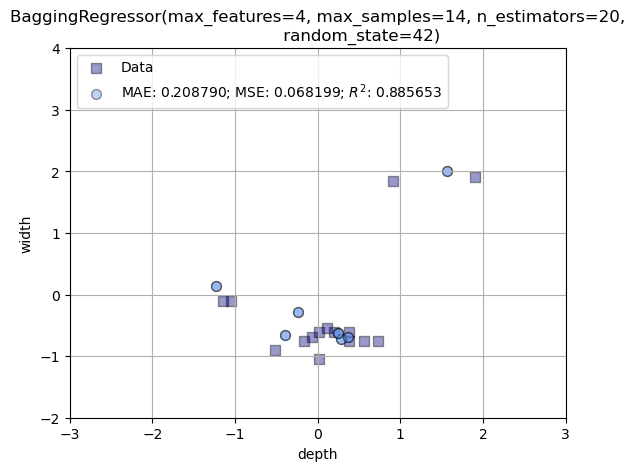

Fitting 5 folds for each of 2560 candidates, totalling 12800 fits
[CV] END estimator__max_features=2, estimator__max_samples=12, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__max_features=2, estimator__max_samples=12, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__max_features=2, estimator__max_samples=14, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__max_features=2, estimator__max_samples=14, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__max_features=2, estimator__max_samples=14, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__max_features=2, estimator__max_samples=14, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__max_features=2, estimator__max_samples=14, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__max_features=2, estimator__max_samples=14, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__max_features=2, estimator__max_sam

[CV] END estimator__max_features=2, estimator__max_samples=12, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__max_features=2, estimator__max_samples=12, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__max_features=2, estimator__max_samples=12, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__max_features=2, estimator__max_samples=12, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__max_features=2, estimator__max_samples=14, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__max_features=2, estimator__max_samples=18, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__max_features=2, estimator__max_samples=18, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__max_features=2, estimator__max_samples=18, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__max_features=2, estimator__max_samples=18, estimator__n_estimators=25; total time=   0.1s
[CV] END 

[CV] END estimator__max_features=2, estimator__max_samples=12, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__max_features=2, estimator__max_samples=12, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__max_features=2, estimator__max_samples=12, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__max_features=2, estimator__max_samples=14, estimator__n_estimators=100; total time=   0.7s
[CV] END estimator__max_features=2, estimator__max_samples=18, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator__max_features=2, estimator__max_samples=24, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__max_features=3, estimator__max_samples=12, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__max_features=3, estimator__max_samples=12, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__max_features=3, estimator__max_samples=12, estimator__n_estimators=20; total time=   0.1s
[CV] EN

[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=10;

[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=1

[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25;

[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=100

[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50;

[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=20;

[CV] END estimator__loss=squared_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10;

[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50;

[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=25;

[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20;

[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25;

[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20;

[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=1

[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20;

[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=1

[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50;

[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators

[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=

[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=10;

[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50

[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10

[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25;

[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=1

[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50;

[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50;

[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=10;

[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25;

[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=1

[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=

[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=50;

[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.1s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20

[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__loss=squared_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20;

[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimato

[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimat

[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimat

[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estima

[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimat

[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimato

[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimat

[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimat

[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimat

[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimat

[CV] END estimator__loss=absolute_error, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimato

[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estima

[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimat

[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimato

[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimato

[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimato

[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimat

[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.8s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.7s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimat

[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.7s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.7s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimat

[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.8s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimato

[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.4s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimator

[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.9s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimato

[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__

[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=absolute_error, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.4s
[

[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.4s
[CV] END estimato

[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator

[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator

[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator

[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator

[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator

[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.7s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.6s
[CV] END estimato

[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator

[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.6s
[CV] END estimato

[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.8s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.9s
[CV] END estimator

[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.6s
[CV] END estimato

[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.8s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.9s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.4s
[CV] END estimator

[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.8s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.8s
[CV] END estimator

[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.8s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.8s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator

[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.8s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.9s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator

[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.8s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.8s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.8s
[CV] END estimato

[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.5s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.6s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.6s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   1.2s
[CV] END estimator_

[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.6s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   1.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.5s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   1.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.9s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.2s
[CV] END estimato

[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.5s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.6s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.9s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.3s
[CV] END estimator_

[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.6s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.3s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.5s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.2s
[CV] END estimator__

[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.2s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.4s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=huber, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__

[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV

[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.3s
[CV]

[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.3s
[CV]

[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.3s
[CV]

[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=1, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.4s
[C

[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.4s
[CV

[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[CV

[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=2, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.3s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.3s
[CV

[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.3s
[CV

[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[C

[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.6s
[C

[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[C

[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=3, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.7s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.7s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.3s
[CV

[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=sqrt, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.6s
[CV]

[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] 

{'estimator__loss': 'squared_error', 'estimator__max_depth': 3, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}
{'estimator__alpha': 0.9, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'friedman_mse', 'estimator__init': None, 'estimator__learning_rate': 0.1, 'estimator__loss': 'squared_error', 'estimator__max_depth': 3, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_iter_no_change': None, 'estimator__random_state': 42, 'estimator__subsample': 1.0, 'estimator__tol': 0.0001, 'estimator__validation_fraction': 0.1, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': GradientBoostingRegressor(max_features='sqrt', min_samples_leaf=3,
                          ran

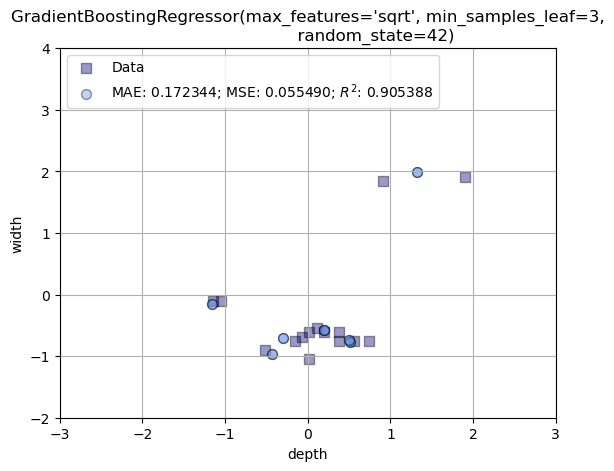

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_sampl

[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.3s
[CV] 

[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.6s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV]

[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__loss=quantile, estimator__max_depth=4, estimator__max_features=log2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.3s
[CV] 

[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_sam

[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samp

[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_sam

[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_sam

[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_sa


[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_sa

[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__criterion=squared_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min

[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_sa

[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=3, estimator__min_sam

[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_sam

[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_sam

[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_sam

[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__m

[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.4s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__mi

[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=squared_error, estimator__max_features=4, estimator__min_sam

[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__m

[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator_

[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__m

[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__m

[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=2, estimator__m

[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__m

[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__m

[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.2s
[CV] END estimator__criterion=absolute_error, estimator__max_features=3, estimator_

[CV] END estimator__criterion=absolute_error, estimator__max_features=4, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=50; total time=   0.3s
[CV] END estimator__criterion=absolute_error, estimator__max_features=4, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__criterion=absolute_error, estimator__max_features=4, estimator__min_samples_leaf=2, estimator__min_samples_split=4, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__criterion=absolute_error, estimator__max_features=4, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.1s
[CV] END estimator__criterion=absolute_error, estimator__max_features=4, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=100; total time=   0.5s
[CV] END estimator__criterion=absolute_error, estimator__max_features=4, estimator

[CV] END estimator__criterion=poisson, estimator__max_features=2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=2, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=100; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=2, estimator__min_samples_leaf=2, estimator__min_samples_split=3, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=2, estimator__min_samples_leaf=2, estimator__min_samp

[CV] END estimator__criterion=poisson, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=100; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=2, estimator__min_samples_leaf=3, estimator__min_sample

[CV] END estimator__criterion=poisson, estimator__max_features=3, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=3, estimator__min_samples_leaf=3, estimator__min_samples_split=3, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=4, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_

/home/green-machine/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1200 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/home/green-machine/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/green-machine/anaconda3/lib/python3.9/site-packages/sklearn/multioutput.py", line 202, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "/home/green-machine/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
   

{'estimator__criterion': 'squared_error', 'estimator__max_features': 2, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 3, 'estimator__n_estimators': 100}
{'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': None, 'estimator__max_features': 2, 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 3, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(max_features=2, min_samples_split=3, random_state=42), 'n_jobs': None}


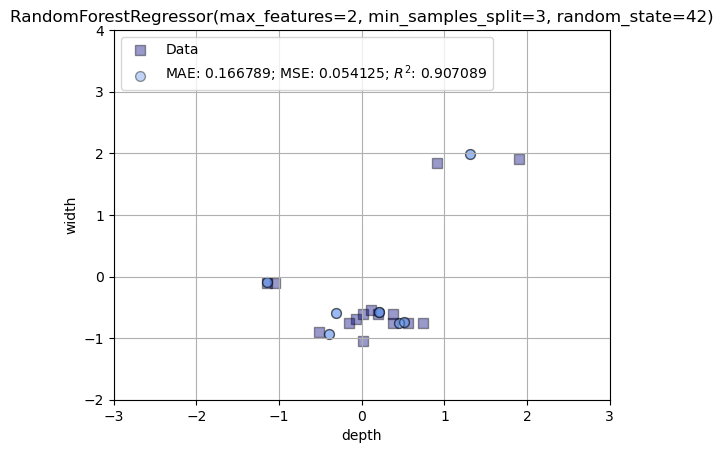

Grid Search Results:
Best Solver In Terms of <MAE> Is:
 RandomForestRegressor(max_features=2, min_samples_split=3, random_state=42)
 MAE = 0.166789

Best Solver In Terms of <MSE> Is:
 RandomForestRegressor(max_features=2, min_samples_split=3, random_state=42)
 MSE = 0.054125

Best Solver In Terms of <R**2> Is:
 RandomForestRegressor(max_features=2, min_samples_split=3, random_state=42)
 R**2 = 0.907089



In [20]:
maes, mses, r2_s = {}, {}, {}

for estimator, param_grid in ESTIMATORS.items():
    regressor = MultiOutputRegressor(estimator)
    gscv = GridSearchCV(
        estimator=regressor,
        param_grid=param_grid,
        cv=CV,
        verbose=2,
        n_jobs=-1
    )
    gscv.fit(X_train, y_train)

    print(gscv.best_params_)

    best_estimator = gscv.best_estimator_
    y_pred = best_estimator.predict(X_test)
    print(best_estimator.get_params())

    maes[best_estimator.get_params()["estimator"]] = mean_absolute_error(
        y_test, y_pred
    )
    mses[best_estimator.get_params()["estimator"]] = mean_squared_error(
        y_test, y_pred
    )
    r2_s[best_estimator.get_params()["estimator"]] = r2_score(
        y_test, y_pred
    )
    # =========================================================================
    # Plot the Results
    # =========================================================================
    plot_multi_output_solver(y_test, y_pred, best_estimator)

    # =========================================================================
    # Save Model
    # =========================================================================
    file_name = f'sklearn_grid_search_{trim_string(str(best_estimator.get_params()["estimator"]))}.joblib'
    dump(best_estimator, Path(MODEL_DIR).joinpath(file_name))


best_mae = min(maes, key=maes.get)
best_mse = min(mses, key=mses.get)
best_r_2 = max(r2_s, key=r2_s.get)
print("Grid Search Results:")
print(
    f"Best Solver In Terms of <MAE> Is:\n"
    f" {best_mae}\n"
    f" MAE = {maes[best_mae]:,.6f}\n"
)
print(
    f"Best Solver In Terms of <MSE> Is:\n"
    f" {best_mse}\n"
    f" MSE = {mses[best_mse]:,.6f}\n"
)
print(
    f"Best Solver In Terms of <R**2> Is:\n"
    f" {best_r_2}\n"
    f" R**2 = {r2_s[best_r_2]:,.6f}\n"
)

# TensorFlow: Deep Learning

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


2022-11-27 18:52:35.092736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-27 18:52:35.092766: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-27 18:52:35.092787: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (green-machine): /proc/driver/nvidia/version does not exist
2022-11-27 18:52:35.093331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
2/2 [==============================] - 0s 125ms/step - loss: 1.3273 - val_loss: 1.4557
Epoch 2/100
2/2 [==============================] - 0s 27ms/step - loss: 1.2827 - val_loss: 1.4143
Epoch 3/100
2/2 [==============================] - 0s 41ms/step - loss: 1.2282 - val_loss: 1.3769
Epoch 4/100
2/2 [==============================] - 0s 36ms/step - loss: 1.2161 - val_loss: 1.3433
Epoch 5/100
2/2 [==============================] - 0s 40ms/step - loss: 1.1736 - val_loss: 1.3151
Epoch 6/100
2/2 [==============================] - 0s 32ms/step - loss: 1.1502 - val_loss: 1.2876
Epoch 7/100
2/2 [==============================] - 0s 42ms/step - loss: 1.1154 - val_loss: 1.2604
Epoch 8/100
2/2 [==============================] - 0s 35ms/step - loss: 1.0837 - val_loss: 1.2336
Epoch 9/100
2/2 [==============================] - 0s 39ms/step - loss: 1.0594 - val_loss: 1.2074
Epoch 10/100
2/2 [==============================] - 0s 37ms/step - loss: 1.0148 - val_loss: 1.1816
Epoch 11/100
2/2 [

Epoch 84/100
2/2 [==============================] - 0s 30ms/step - loss: 0.3445 - val_loss: 0.3466
Epoch 85/100
2/2 [==============================] - 0s 27ms/step - loss: 0.3165 - val_loss: 0.3445
Epoch 86/100
2/2 [==============================] - 0s 29ms/step - loss: 0.3596 - val_loss: 0.3435
Epoch 87/100
2/2 [==============================] - 0s 27ms/step - loss: 0.3409 - val_loss: 0.3433
Epoch 88/100
2/2 [==============================] - 0s 27ms/step - loss: 0.3415 - val_loss: 0.3432
Epoch 89/100
2/2 [==============================] - 0s 35ms/step - loss: 0.3486 - val_loss: 0.3430
Epoch 90/100
2/2 [==============================] - 0s 41ms/step - loss: 0.3240 - val_loss: 0.3421
Epoch 91/100
2/2 [==============================] - 0s 29ms/step - loss: 0.3587 - val_loss: 0.3408
Epoch 92/100
2/2 [==============================] - 0s 27ms/step - loss: 0.3332 - val_loss: 0.3400
Epoch 93/100
2/2 [==============================] - 0s 27ms/step - loss: 0.3621 - val_loss: 0.3391
Epoch 94/1

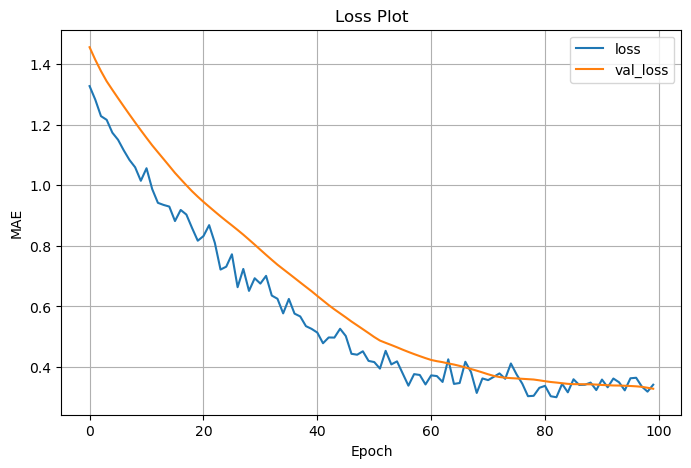

In [21]:
model = Sequential()
model.add(
    Dense(32,
          input_dim=X.shape[1],
          kernel_initializer="he_uniform",
          activation="relu")
)
model.add(Dropout(.05))
model.add(Dense(y.shape[1]))
model.compile(optimizer="adam", loss="mae")
# =============================================================================
# Architecture
# =============================================================================
model.summary()

model_history = model.fit(X_train, y_train, verbose=1,
                          epochs=100, validation_split=.2)

model.evaluate(X_test, y_test, verbose=0)

# =============================================================================
# Plot the Results
# =============================================================================
plot_model_train_val_losses(model_history.history)

# >> To Production

In [22]:
# =============================================================================
# Save Model
# =============================================================================
model.save(MODEL_DIR)
# =============================================================================
# Load Model
# =============================================================================
new_model = tf.keras.models.load_model(MODEL_DIR)
# =============================================================================
# Architecture
# =============================================================================
new_model.summary()

INFO:tensorflow:Assets written to: ../models/assets
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [23]:
# clf.predict(np.array([0.8, -0.456630, -2.022210,  0.078087]).reshape(1, -1))

[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=1, estimator__min_samples_

[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=3, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=4, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_

[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=3, estimator__min_samples_split=4, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=25; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=10; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=20; total time=   0.0s
[CV] END estimator__criterion=poisson, estimator__max_features=4, estimator__min_samples_leaf=4, estimator__min_samples_